In [1]:
################ Higher moments global #################

In [1]:
%%time
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
import dask
#import daskdataframe as dd
import matplotlib.pyplot as plt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
%run data_handler.ipynb
#np.set_printoptions(threshold=np.inf)

CPU times: user 3.79 s, sys: 405 ms, total: 4.19 s
Wall time: 9.29 s


In [140]:
def quantf(arr,qsteps=100,nboot=100):
    #Takes in a 1d-array,resamples it nboot times and
    #returns the quantile function for each iteration
    print(arr.shape)
    n            = arr.size
    qboots       = np.zeros((nboot,qsteps))
    quants       = np.arange(0,1,1/qsteps)
    for i in range(nboot):
        new_sample   = np.random.choice(arr,replace=True,size=n)
        qboots[i,:]  = np.quantile(new_sample,quants)
    
    return qboots   

In [122]:
%%time
arr1        = np.arange(1,20,1)
qtest       = quantf(arr1,10,5)
qtest

CPU times: user 23.6 ms, sys: 1.02 ms, total: 24.6 ms
Wall time: 22.8 ms


array([[ 2. ,  2. ,  2.6,  4.2,  6. ,  8. , 10.6, 11. , 13.4, 14.4],
       [ 2. ,  3.8,  4. ,  5.4,  7.2,  8. , 11.6, 14.6, 15.4, 17. ],
       [ 1. ,  1. ,  1.6,  3.4,  5.2,  6. , 10.6, 13.2, 15.4, 18.2],
       [ 1. ,  1. ,  2.2,  3.4,  5.2,  6. ,  9.6, 14. , 14.4, 17. ],
       [ 3. ,  4.6,  9. ,  9.4, 12.4, 14. , 15. , 15.6, 17. , 17.2]])

In [143]:
tgw_test   = tgw.sel(lat=LAT,lon=LON,method='nearest')
tgw_test  

<xarray.DataArray 'TREFHTMX' (mtime: 3100)>
dask.array<getitem, shape=(3100,), dtype=float32, chunksize=(31,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 43.82
    lon      float64 245.0
    member   (mtime) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    time     (mtime) object dask.array<chunksize=(3100,), meta=np.ndarray>
Dimensions without coordinates: mtime
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [148]:
def quants(obj,dim):
    # note: apply always moves core dimensions to the end
    return xr.apply_ufunc(
        quantf, obj,output_core_dims=[['dim']]
    )

In [ ]:
%%time 
qtest= quants(tgw_test.compute(),iteration)

In [2]:
#LAT        = 48.5
#LON        = 236.25
LAT        = 44.0682
LON        = 360-114.7420
savefigs   = '/global/scratch/users/harsha/savefigs/Nov15/'
cesm2_path = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals      = '/global/scratch/users/harsha/LENS/cesm2/cvals/global/'
temp_path  = cvals+'temps/'
quant_path = cvals+'quantiles/'
quant_cis  = quant_path+'boot_cis/'
cvals_us   = '/global/scratch/users/harsha/LENS/cesm2/cvals/conus/'
loc        = 'columbia'
cvals1     = '/global/scratch/users/harsha/LENS/cesm2/tmax_mem'

In [3]:
pi_yr0 = '1900'
pi_yr1 = '1930'
ic_yr0 = '2070'
ic_yr1 = '2100'
doy      = 211 # day_of_year
date     = 'Jul30'

In [4]:
#job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192'] 
cluster = dask_jobqueue.SLURMCluster(queue="lr6", cores=20, walltime='6:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(10)

In [5]:
cluster

In [6]:
%%time
ds_ssp  = xr.open_mfdataset(cesm2_path+'ssp370_cesm2tmax.zarr',engine='zarr')
ds_hist = xr.open_mfdataset(cesm2_path+'bhist_cesm2tmax.zarr',engine='zarr')

CPU times: user 1.06 s, sys: 184 ms, total: 1.24 s
Wall time: 4.28 s


In [7]:
%%time
twg  = ds_ssp.TREFHTMX.sel(time=ds_ssp.time.dt.dayofyear==doy).sel(time=slice(ic_yr0,ic_yr1))
tnwg = ds_hist.TREFHTMX.sel(time=ds_hist.time.dt.dayofyear==doy).sel(time=slice(pi_yr0,pi_yr1))
        

CPU times: user 233 ms, sys: 9.69 ms, total: 243 ms
Wall time: 240 ms


In [8]:
twg

,Array,Chunk
Bytes,653.91 MiB,2.11 MiB
Shape,"(31, 192, 288, 100)","(10, 192, 288, 1)"
Count,2201 Tasks,400 Chunks
Type,float32,numpy.ndarray


In [11]:
%%time
tgnw = tnwg.stack(mtime=('member','time'),create_index=False)
tgw  = twg.stack(mtime=('member','time'),create_index=False)

CPU times: user 15 ms, sys: 0 ns, total: 15 ms
Wall time: 13.6 ms


In [12]:
tgc = (tgw - tgw.mean('mtime'))*(tgnw.std('mtime')/tgw.std('mtime'))+ tgnw.mean('mtime')

In [18]:
tgnw_path = temp_path+'tnw'+date+'_'+pi_yr0+'_'+pi_yr1+'_global.zarr'
tgw_path  = temp_path+'tw'+date+'_'+ic_yr0+'_'+ic_yr1+'_global.zarr'
tgc_path  = temp_path+'twc'+date+'_'+ic_yr0+'_'+ic_yr1+'_global.zarr'
print(tgnw_path) 
print(tgw_path)
print(tgc_path)

/global/scratch/users/harsha/LENS/cesm2/cvals/global/temps/tnwJul30_1900_1930_global.zarr
/global/scratch/users/harsha/LENS/cesm2/cvals/global/temps/twJul30_2070_2100_global.zarr
/global/scratch/users/harsha/LENS/cesm2/cvals/global/temps/twcJul30_2070_2100_global.zarr


In [64]:
%%time
#Open conus data
tgnw = xr.open_mfdataset(tgnw_path,engine='zarr')
tgw  = xr.open_mfdataset(tgw_path,engine='zarr')
tgc  = xr.open_mfdataset(tgc_path,engine='zarr')
tgw  = tgw.TREFHTMX
tgnw = tgnw.TREFHTMX
tgc  = tgc.TREFHTMX
tgw

CPU times: user 95.5 ms, sys: 16.2 ms, total: 112 ms
Wall time: 111 ms


<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, mtime: 3100)>
dask.array<open_dataset-d8aa681214937eb6955504520d71f58cTREFHTMX, shape=(192, 288, 3100), dtype=float32, chunksize=(192, 288, 31), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (mtime) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    time     (mtime) object dask.array<chunksize=(3100,), meta=np.ndarray>
Dimensions without coordinates: mtime
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [15]:
%%time
#########
quants  = np.arange(0,1,0.001)
qgw     = tgw.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qgnw    = tgnw.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qgc     = tgc.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qgwa    = qgw-qgnw
qgca    = qgc-qgnw
########################
qgwa   = qgwa.rename({'quantile':'permilles'})
qgca   = qgca.rename({'quantile':'permilles'})
qgw    = qgw.rename({'quantile':'permilles'}) 
qgnw   = qgnw.rename({'quantile':'permilles'}) 
qgc    = qgc.rename({'quantile':'permilles'})

CPU times: user 81.9 ms, sys: 5.04 ms, total: 86.9 ms
Wall time: 84.1 ms


In [20]:
#### Quantile paths-Conus
qgw_path   = quant_path+'qw'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
qgnw_path  = quant_path+'qnw'+date+'_'+pi_yr0+'_'+pi_yr1+'.zarr'
qgc_path   = quant_path+'qc'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
qgnw_path

'/global/scratch/users/harsha/LENS/cesm2/cvals/global/quantiles/qnwJul30_1900_1930.zarr'

In [40]:
%%time
qgw.to_dataset().to_zarr(qgw_path,mode='w')
qgnw.to_dataset().to_zarr(qgnw_path,mode='w')
qgc.to_dataset().to_zarr(qgc_path,mode='w')

CPU times: user 2min 22s, sys: 6.8 s, total: 2min 29s
Wall time: 23min


In [21]:
######### CONUS#################
qgnw  = xr.open_mfdataset(qgnw_path,engine='zarr')
qgw   = xr.open_mfdataset(qgw_path,engine='zarr')
qgc   = xr.open_mfdataset(qgc_path,engine='zarr')
qgnw  = qgnw.TREFHTMX
qgw   = qgw.TREFHTMX
qgc   = qgc.TREFHTMX
qgwa  = qgw-qgnw 
qgca  = qgc-qgnw #w= warming, a = anomaly
qgwa

<xarray.DataArray 'TREFHTMX' (permilles: 1000, lat: 192, lon: 288)>
dask.array<sub, shape=(1000, 192, 288), dtype=float64, chunksize=(1000, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * permilles  (permilles) float64 0.0 0.001 0.002 0.003 ... 0.997 0.998 0.999

In [68]:
%%time
tgw  = xr.open_mfdataset(tgw_path,engine='zarr')
tgw  = tgw.TREFHTMX

CPU times: user 17.9 ms, sys: 3 ms, total: 20.9 ms
Wall time: 20.8 ms


In [73]:
%%time
tgwb2  = xs.resampling.resample_iterations_idx(tgw.persist(),100,'mtime') 

CPU times: user 279 ms, sys: 30.5 ms, total: 310 ms
Wall time: 299 ms


In [74]:
tgwb2

<xarray.DataArray (mtime: 3100, lat: 192, lon: 288, iteration: 100)>
dask.array<transpose, shape=(3100, 192, 288, 100), dtype=float64, chunksize=(31, 192, 288, 100), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member     (mtime) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    time       (mtime) object dask.array<chunksize=(3100,), meta=np.ndarray>
  * iteration  (iteration) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
Dimensions without coordinates: mtime

In [75]:
tgwb

<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, mtime: 3100, iteration: 100)>
dask.array<transpose, shape=(192, 288, 3100, 100), dtype=float32, chunksize=(192, 288, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member     (mtime) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    time       (mtime) object dask.array<chunksize=(3100,), meta=np.ndarray>
  * iteration  (iteration) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
Dimensions without coordinates: mtime
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [72]:
%%time
tgwb =  xs.resample_iterations(tgw.persist(),100,'mtime') 

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 31 times more chunks
  return self.array[key]
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 31 times more chunks
  return self.array[key]
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 31 times more chunks
  return self.array[key]
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 31 times more chunks
  return self.array[key]
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: Performanc

CPU times: user 21.9 s, sys: 1.55 s, total: 23.4 s
Wall time: 23.1 s


In [71]:
%%time
tgw1b = xs.resample_iterations(tgw1,100,'mtime')

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 31 times more chunks
  return self.array[key]
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 31 times more chunks
  return self.array[key]
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 31 times more chunks
  return self.array[key]
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 31 times more chunks
  return self.array[key]
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: Performanc

CPU times: user 18.8 s, sys: 692 ms, total: 19.5 s
Wall time: 19.3 s


In [65]:
%%time
tgw = tgw.persist()
tgw

CPU times: user 405 ms, sys: 19.1 ms, total: 424 ms
Wall time: 415 ms


<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, mtime: 3100)>
dask.array<open_dataset-d8aa681214937eb6955504520d71f58cTREFHTMX, shape=(192, 288, 3100), dtype=float32, chunksize=(192, 288, 31), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (mtime) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    time     (mtime) object dask.array<chunksize=(3100,), meta=np.ndarray>
Dimensions without coordinates: mtime
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [48]:
tgw

<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, mtime: 3100)>
dask.array<open_dataset-d8aa681214937eb6955504520d71f58cTREFHTMX, shape=(192, 288, 3100), dtype=float32, chunksize=(192, 288, 31), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (mtime) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    time     (mtime) object dask.array<chunksize=(3100,), meta=np.ndarray>
Dimensions without coordinates: mtime
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [42]:
######### Calculate bootstrap confidence intervals for quatiles
#### Global############
tgnw= tgnw.chunk(dict(mtime=-1))
tgw = tgw.chunk(dict(mtime=-1))
tgc = tgc.chunk(dict(mtime=-1))
dask.config.set({"array.slicing.split_large_chunks": True})  #Split large chunks
tgw

<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, mtime: 3100)>
dask.array<rechunk-merge, shape=(192, 288, 3100), dtype=float32, chunksize=(192, 288, 3100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (mtime) int64 dask.array<chunksize=(3100,), meta=np.ndarray>
    time     (mtime) object dask.array<chunksize=(3100,), meta=np.ndarray>
Dimensions without coordinates: mtime
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [17]:
# ###### Split temps by lats #######
 tgnw_lat1  = tgnw.isel(lat=slice(None,48))
# tgnw_lat2  = tgnw.isel(lat=slice(48,96))
# tgnw_lat3  = tgnw.isel(lat=slice(96,144))
# tgnw_lat4  = tgnw.isel(lat=slice(144,192))
# tgw_lat1   = tgw.isel(lat=slice(None,48))
# tgw_lat2   = tgw.isel(lat=slice(48,96))
# tgw_lat3   = tgw.isel(lat=slice(96,144))
# tgw_lat4   = tgw.isel(lat=slice(144,192))
# tgwc_lat1  = tgc.isel(lat=slice(None,48))
# tgwc_lat2  = tgc.isel(lat=slice(48,96))
# tgwc_lat3  = tgc.isel(lat=slice(96,144))
# tgwc_lat4  = tgc.isel(lat=slice(144,192))
# tgwc_lat4

IndentationError: unexpected indent (2540709980.py, line 2)

In [ ]:
# %%time
# qgca.sel(lat=LAT,lon=LON,method='nearest').plot()
# qgwa.sel(lat=LAT,lon=LON,method='nearest').plot()
# yzero = np.zeros(1000)
# plt.plot(quants,yzero)

In [35]:
%%time
############ CONUS ####################
nboot        = 1000
# tgnw_lat1b   = xs.resample_iterations(tgnw_lat1,nboot,'mtime')
# tgnw_lat2b   = xs.resample_iterations(tgnw_lat2,nboot,'mtime')
# tgnw_lat3b   = xs.resample_iterations(tgnw_lat3,nboot,'mtime')
# tgnw_lat4b   = xs.resample_iterations(tgnw_lat4,nboot,'mtime')

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.5 µs


In [24]:
%%time
#########################################
# tgw_lat1b   = xs.resample_iterations(tgw_lat1,nboot,'mtime')
# tgw_lat2b   = xs.resample_iterations(tgw_lat2,nboot,'mtime')
# tgw_lat3b   = xs.resample_iterations(tgw_lat3,nboot,'mtime')
# tgw_lat4b   = xs.resample_iterations(tgw_lat4,nboot,'mtime')

CPU times: user 49.7 s, sys: 1.13 s, total: 50.8 s
Wall time: 49 s


In [45]:
%%time
######################################
# tgwc_lat1b   = xs.resample_iterations(tgwc_lat1,nboot,'mtime')
# tgwc_lat2b   = xs.resample_iterations(tgwc_lat2,nboot,'mtime')
# tgwc_lat3b   = xs.resample_iterations(tgwc_lat3,nboot,'mtime')
# tgwc_lat4b   = xs.resample_iterations(tgwc_lat4,nboot,'mtime')
########################################
tgnwb   = xs.resample_iterations(tgnw,nboot,'mtime')
tgwb    = xs.resample_iterations(tgw,nboot,'mtime')
tgwcb   = xs.resample_iterations(tgc,nboot,'mtime')

CPU times: user 19.7 s, sys: 431 ms, total: 20.1 s
Wall time: 19.8 s


In [60]:
tgw

<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, mtime: 3100)>
dask.array<open_dataset-d8aa681214937eb6955504520d71f58cTREFHTMX, shape=(192, 288, 3100), dtype=float32, chunksize=(192, 288, 31), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (mtime) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    time     (mtime) object dask.array<chunksize=(3100,), meta=np.ndarray>
Dimensions without coordinates: mtime
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [76]:
tgw = tgw.persist()
tgw

<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, mtime: 3100)>
dask.array<open_dataset-d8aa681214937eb6955504520d71f58cTREFHTMX, shape=(192, 288, 3100), dtype=float32, chunksize=(192, 288, 31), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (mtime) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    time     (mtime) object dask.array<chunksize=(3100,), meta=np.ndarray>
Dimensions without coordinates: mtime
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [111]:
%%time
tgw_loc     = tgw.sel(lat=slice(LAT,LAT+100),lon=slice(LON,LON+100))
tgw_loc     = tgw_loc.chunk(dict(mtime=-1,lat=1,lon=1))
tgwb_loc    = xs.resampling.resample_iterations_idx(tgw_loc,1000,'mtime')
tgwb_loc.compute()

CPU times: user 726 ms, sys: 26.8 ms, total: 753 ms
Wall time: 613 ms


<xarray.DataArray (mtime: 3100, lat: 49, lon: 80, iteration: 1000)>
dask.array<transpose, shape=(3100, 49, 80, 1000), dtype=float64, chunksize=(3100, 1, 1, 1000), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 44.76 45.71 46.65 47.59 ... 87.17 88.12 89.06 90.0
  * lon        (lon) float64 246.2 247.5 248.8 250.0 ... 341.2 342.5 343.8 345.0
    member     (mtime) int64 dask.array<chunksize=(3100,), meta=np.ndarray>
    time       (mtime) object dask.array<chunksize=(3100,), meta=np.ndarray>
  * iteration  (iteration) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Dimensions without coordinates: mtime

In [106]:
%%time
quants    = np.arange(0,1,0.001)
qgwb_loc  = tgwb_loc.quantile(quants,dim='mtime')
qgwb_loc.compute()

Task exception was never retrieved
future: <Task finished name='Task-1438090' coro=<Client._gather.<locals>.wait() done, defined at /global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/distributed/client.py:2002> exception=AllExit()>
Traceback (most recent call last):
  File "/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/distributed/client.py", line 2011, in wait
    raise AllExit()
distributed.client.AllExit


ValueError: axes don't match array

In [27]:
# %%time
# ############ Conus ################
# quants       = np.arange(0,1,0.001)
# qgnw_lat1b   = tgnw_lat1b.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
# qgnw_lat2b   = tgnw_lat2b.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
# qgnw_lat3b   = tgnw_lat3b.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
# qgnw_lat4b   = tgnw_lat4b.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
# #######################################
# qgw_lat1b    = tgw_lat1b.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
# qgw_lat2b    = tgw_lat2b.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
# qgw_lat3b    = tgw_lat3b.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
# qgw_lat4b    = tgw_lat4b.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
# ########################################
# qgwc_lat1b   = tgwc_lat1b.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
# qgwc_lat2b   = tgwc_lat2b.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
# qgwc_lat3b   = tgwc_lat3b.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
# qgwc_lat4b   = tgwc_lat4b.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
# ########################################
# qgwa_lat1b   = qgw_lat1b - qgnw_lat1b
# qgwa_lat2b   = qgw_lat2b - qgnw_lat2b
# qgwa_lat3b   = qgw_lat3b - qgnw_lat3b
# qgwa_lat4b   = qgw_lat4b - qgnw_lat4b
# ######################################
# qgca_lat1b   = qgwc_lat1b - qgnw_lat1b
# qgca_lat2b   = qgwc_lat2b - qgnw_lat2b
# qgca_lat3b   = qgwc_lat3b - qgnw_lat3b
# qgca_lat4b   = qgwc_lat4b - qgnw_lat4b

CPU times: user 1.15 s, sys: 11 ms, total: 1.16 s
Wall time: 1.14 s


In [47]:
%%time
############ Conus ################
quants  = np.arange(0,1,0.001)
qgnwb   = tgnwb.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qgwb    = tgwb.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qgwcb   = tgwcb.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qgwab   = qgwb - qgnwb
qgcab   = qgwcb - qgnwb
qgcab

CPU times: user 170 ms, sys: 1.92 ms, total: 172 ms
Wall time: 170 ms


,Array,Chunk
Bytes,411.99 GiB,421.88 MiB
Shape,"(1000, 192, 288, 1000)","(1000, 192, 288, 1)"
Count,61204 Tasks,1000 Chunks
Type,float64,numpy.ndarray


In [48]:
# ############# CONUS #################
# qgwb_path    = cvals_us+'qgwb'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
# qgnwb_path   = cvals_us+'qgnwb'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
# qgcb_path    = cvals_us+'qgcb'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'

# qgwab_path   = cvals_us+'qgwab'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
# qgcab_path   = cvals_us+'qucab'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
# qgwa_lat1b      = qgwa_lat1b.rename({'quantile':'permilles'})
# qgwa_lat2b      = qgwa_lat2b.rename({'quantile':'permilles'})
# qgwa_lat3b      = qgwa_lat3b.rename({'quantile':'permilles'})
# qgwa_lat4b      = qgwa_lat4b.rename({'quantile':'permilles'})
# ######################################
# qgca_lat1b      = qgca_lat1b.rename({'quantile':'permilles'})
# qgca_lat2b      = qgca_lat2b.rename({'quantile':'permilles'})
# qgca_lat3b      = qgca_lat3b.rename({'quantile':'permilles'})
# qgca_lat4b      = qgca_lat4b.rename({'quantile':'permilles'})
#########################
qgwab         = qgwab.rename({'quantile':'permilles'})
qgcab         = qgcab.rename({'quantile':'permilles'})
qgcab

,Array,Chunk
Bytes,411.99 GiB,421.88 MiB
Shape,"(1000, 192, 288, 1000)","(1000, 192, 288, 1)"
Count,61204 Tasks,1000 Chunks
Type,float64,numpy.ndarray


In [49]:
qgwa_cilb = qgwab.chunk(dict(iteration=-1)).quantile(0.025,dim='iteration')
qgwa_ciub = qgwab.chunk(dict(iteration=-1)).quantile(0.975,dim='iteration')
qgca_cilb = qgcab.chunk(dict(iteration=-1)).quantile(0.025,dim='iteration')
qgca_ciub = qgcab.chunk(dict(iteration=-1)).quantile(0.975,dim='iteration')
qgca_ci   = xr.concat([qgca_cilb,qgca_ciub],dim='quantile')
qgwa_ci   = xr.concat([qgwa_cilb,qgwa_ciub],dim='quantile')
qgwa_ci

<xarray.DataArray 'TREFHTMX' (quantile: 2, permilles: 1000, lat: 192, lon: 288)>
dask.array<concatenate, shape=(2, 1000, 192, 288), dtype=float64, chunksize=(1, 1000, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * permilles  (permilles) float64 0.0 0.001 0.002 0.003 ... 0.997 0.998 0.999
  * quantile   (quantile) float64 0.025 0.975

In [50]:
%%time
qgwa_cipath = quant_cis+'qgwa_ci'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
qgca_cipath = quant_cis+'qgca_ci'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
qgca_cipath

CPU times: user 18 µs, sys: 1 µs, total: 19 µs
Wall time: 22.2 µs


'/global/scratch/users/harsha/LENS/cesm2/cvals/global/quantiles/boot_cis/qgca_ciJul30_2070_2100.zarr'

In [51]:
qgwa_ci

<xarray.DataArray 'TREFHTMX' (quantile: 2, permilles: 1000, lat: 192, lon: 288)>
dask.array<concatenate, shape=(2, 1000, 192, 288), dtype=float64, chunksize=(1, 1000, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * permilles  (permilles) float64 0.0 0.001 0.002 0.003 ... 0.997 0.998 0.999
  * quantile   (quantile) float64 0.025 0.975

In [ ]:
%%time
qgwa_ci.to_dataset().to_zarr(qgwa_cipath,mode='w')

In [ ]:
%%time
qgca_ci.to_dataset().to_zarr(qgca_cipath,mode='w')

In [ ]:
qgwa_ci2 = xr.open_mfdataset(qgwa_cipath,engine='zarr')
qgwa_ci2

In [ ]:
qgwa2.sel(lat)

In [27]:
# %%time
# ######## CONUS ############
# qgwa_lat1cilb = qgwa_lat1b.chunk(dict(iteration=-1)).quantile(0.025,dim='iteration')
# qgwa_lat2cilb = qgwa_lat2b.chunk(dict(iteration=-1)).quantile(0.025,dim='iteration')
# qgwa_lat3cilb = qgwa_lat3b.chunk(dict(iteration=-1)).quantile(0.025,dim='iteration')
# qgwa_lat4cilb = qgwa_lat4b.chunk(dict(iteration=-1)).quantile(0.025,dim='iteration')
# #############
# qgwa_lat1ciub = qgwa_lat1b.chunk(dict(iteration=-1)).quantile(0.975,dim='iteration')
# qgwa_lat2ciub = qgwa_lat2b.chunk(dict(iteration=-1)).quantile(0.975,dim='iteration')
# qgwa_lat3ciub = qgwa_lat3b.chunk(dict(iteration=-1)).quantile(0.975,dim='iteration')
# qgwa_lat4ciub = qgwa_lat4b.chunk(dict(iteration=-1)).quantile(0.975,dim='iteration')
# ##################################################
# qgca_lat1cilb = qgca_lat1b.chunk(dict(iteration=-1)).quantile(0.025,dim='iteration')
# qgca_lat2cilb = qgca_lat2b.chunk(dict(iteration=-1)).quantile(0.025,dim='iteration')
# qgca_lat3cilb = qgca_lat3b.chunk(dict(iteration=-1)).quantile(0.025,dim='iteration')
# qgca_lat4cilb = qgca_lat4b.chunk(dict(iteration=-1)).quantile(0.025,dim='iteration')
# #####################################################
# qgca_lat1ciub = qgca_lat1b.chunk(dict(iteration=-1)).quantile(0.975,dim='iteration')
# qgca_lat2ciub = qgca_lat2b.chunk(dict(iteration=-1)).quantile(0.975,dim='iteration')
# qgca_lat3ciub = qgca_lat3b.chunk(dict(iteration=-1)).quantile(0.975,dim='iteration')
# qgca_lat4ciub = qgca_lat4b.chunk(dict(iteration=-1)).quantile(0.975,dim='iteration')

In [29]:
# ########## CONUS ##############
# qgwa_l1cilbpath = quant_cis+'qgwa_lat1cilb'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
# qgwa_l2cilbpath = quant_cis+'qgwa_lat2cilb'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
# qgwa_l3cilbpath = quant_cis+'qgwa_lat3cilb'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
# qgwa_l4cilbpath = quant_cis+'qgwa_lat4cilb'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
# ####################
# qgwa_l1ciubpath = quant_cis+'qgwa_lat1ciub'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
# qgwa_l2ciubpath = quant_cis+'qgwa_lat2ciub'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
# qgwa_l3ciubpath = quant_cis+'qgwa_lat3ciub'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
# qgwa_l4ciubpath = quant_cis+'qgwa_lat4ciub'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
# #########################
# qgca_l1cilbpath = quant_cis+'qgca_lat1cilb'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
# qgca_l2cilbpath = quant_cis+'qgca_lat2cilb'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
# qgca_l3cilbpath = quant_cis+'qgca_lat3cilb'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
# qgca_l4cilbpath = quant_cis+'qgca_lat4ilb'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
# ##########################
# qgca_l1ciubpath = quant_cis+'qgca_lat1ciub'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
# qgca_l2ciubpath = quant_cis+'qgca_lat2ciub'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
# qgca_l3ciubpath = quant_cis+'qgca_lat3ciub'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
# qgca_l4ciubpath = quant_cis+'qgca_lat4ciub'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
# qgca_l1cilbpath

'/global/scratch/users/harsha/LENS/cesm2/cvals/global/quantiles/boot_cis/qgca_lat1cilbJan1_2070_2100.zarr'

In [30]:
qgwa_lat1cilb

<xarray.DataArray 'TREFHTMX' (permilles: 1000, lat: 48, lon: 288)>
dask.array<getitem, shape=(1000, 48, 288), dtype=float64, chunksize=(1000, 48, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... -47.59 -46.65 -45.71
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * permilles  (permilles) float64 0.0 0.001 0.002 0.003 ... 0.997 0.998 0.999
    quantile   float64 0.025

In [ ]:
%%time


In [ ]:
%%time
#### Save bootstrap CIs #####
qgwa_lat1ciub.to_dataset().to_zarr(qgwa_l1ciubpath,mode='w')
#qgwa_lat2ciub.to_dataset().to_zarr(qgwa_l2ciubpath,mode='w')
#qgwa_lat3ciub.to_dataset().to_zarr(qgwa_l3ciubpath,mode='w')
#qgwa_lat4ciub.to_dataset().to_zarr(qgwa_l4ciubpath,mode='w')

In [ ]:
%%time
#### Save bootstrap CIs #####
qgwa_lat1cilb.to_dataset().to_zarr(qgwa_l1cilbpath,mode='w')
qgwa_lat2cilb.to_dataset().to_zarr(qgwa_l2cilbpath,mode='w')
qgwa_lat3cilb.to_dataset().to_zarr(qgwa_l3cilbpath,mode='w')
qgwa_lat4cilb.to_dataset().to_zarr(qgwa_l4cilbpath,mode='w')

In [ ]:
%%time
#### Save bootstrap CIs #####
qgca_lat1cilb.to_dataset().to_zarr(qgca_l1cilbpath,mode='w')
qgca_lat2cilb.to_dataset().to_zarr(qgca_l2cilbpath,mode='w')
qgca_lat3cilb.to_dataset().to_zarr(qgca_l3cilbpath,mode='w')
qgca_lat4cilb.to_dataset().to_zarr(qgca_l4cilbpath,mode='w')

In [ ]:
%%time
#### Save bootstrap CIs #####
qgca_lat1ciub.to_dataset().to_zarr(qgca_l1ciubpath,mode='w')
qgca_lat2ciub.to_dataset().to_zarr(qgca_l2ciubpath,mode='w')
qgca_lat3ciub.to_dataset().to_zarr(qgca_l3ciubpath,mode='w')
qgca_lat4ciub.to_dataset().to_zarr(qgca_l4ciubpath,mode='w')

In [ ]:
%%time
qgwa_cilb.to_dataset().to_zarr(qgwa_cilbpath,mode='w')

In [ ]:
%%time
qgca_ciub.to_dataset().to_zarr(qgca_ciubpath,mode='w')

In [ ]:
%%time
qgca_cilb.to_dataset().to_zarr(qgca_cilbpath,mode='w')

In [ ]:
a=10

In [12]:
%%time
qgwa_ciub = xr.open_mfdataset(qgwa_ciubpath,engine='zarr')
qgwa_cilb = xr.open_mfdataset(qgwa_cilbpath,engine='zarr')

qgca_ciub = xr.open_mfdataset(qgca_ciubpath,engine='zarr')
qgca_cilb = xr.open_mfdataset(qgca_cilbpath,engine='zarr')
#quca_cilb = quca_cilb.TREFHTMX.drop('quantile')
#quca_ciub = quca_ciub.TREFHTMX.drop('quantile')
#quca_ci   = xr.concat([quca_cilb,quca_ciub],dim='quantile')
qgca_cilb

<xarray.Dataset>
Dimensions:    (permilles: 1000, lat: 192, lon: 288)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * permilles  (permilles) float64 0.0 0.001 0.002 0.003 ... 0.997 0.998 0.999
    quantile   float64 ...
Data variables:
    TREFHTMX   (permilles, lat, lon) float64 dask.array<chunksize=(1000, 192, 288), meta=np.ndarray>

CPU times: user 709 ms, sys: 220 ms, total: 929 ms
Wall time: 2.31 s


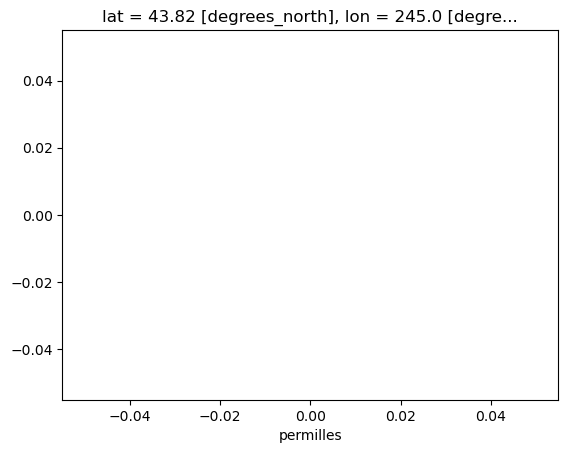

In [14]:
%%time
qgca_cilb.sel(lat=LAT,lon=LON,method='nearest').to_array().plot()

In [39]:
%%time 
qus_lbfracn = ((quca_cilb >0)).sum(dim='permilles')/1000
qus_ubfracn = ((quca_ciub >0)).sum(dim='permilles')/1000

CPU times: user 9 ms, sys: 27 µs, total: 9.03 ms
Wall time: 8.65 ms


In [68]:
quca_fracnp  = ((quca_ci.sel(quantile=0.05)>0) & (quca_ci.sel(quantile=0.95)>0))\
                .sum(dim='permilles')/1000
quca_fracnn  = ((quca_ci.sel(quantile=0.05)<0) & (quca_ci.sel(quantile=0.95)<0))\
                .sum(dim='permilles')/1000

In [80]:
quca_fracn  = quca_fracnp +quca_fracnn
quca_fracn  = quca_fracn.TREFHTMX
quca_fracnp = quca_fracnp.TREFHTMX
quca_fracnn = quca_fracnn.TREFHTMX
quca_fracn

<xarray.DataArray 'TREFHTMX' (lat: 26, lon: 46)>
dask.array<add, shape=(26, 46), dtype=float64, chunksize=(26, 46), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 24.97 25.92 26.86 27.8 ... 45.71 46.65 47.59 48.53
  * lon      (lon) float64 236.2 237.5 238.8 240.0 ... 288.8 290.0 291.2 292.5

In [18]:
%%time
### Check for location
yzeros        = np.zeros(1000)
print(LAT,LON)
quca_cilb_loc = quca_cilb.sel(lat=LAT,lon=LON,method='nearest')
quca_ciub_loc = quca_ciub.sel(lat=LAT,lon=LON,method='nearest')
quwa_cilb_loc = quwa_cilb.sel(lat=LAT,lon=LON,method='nearest')
quwa_ciub_loc = quwa_ciub.sel(lat=LAT,lon=LON,method='nearest')
quca_loc      = quca.sel(lat=LAT,lon=LON,method='nearest')
quwa_loc      = quwa.sel(lat=LAT,lon=LON,method='nearest')

quca_ci_loc   = xr.concat([quca_cilb_loc,quca_ciub_loc],dim='quantile')

quca_fp       = ((quca_ci_loc.sel(quantile=0.05)>0) & (quca_ci_loc.sel(quantile=0.95)>0))\
                .sum(dim='permilles')/1000
quca_fn       = ((quca_ci_loc.sel(quantile=0.05)<0) & (quca_ci_loc.sel(quantile=0.95)<0))\
                .sum(dim='permilles')/1000
quca_fp       = quca_fp.TREFHTMX
quca_fn       = quca_fn.TREFHTMX
quca_f        = quca_fp + quca_fn

quca_cilb_loc = quca_cilb_loc.TREFHTMX
quca_ciub_loc = quca_ciub_loc.TREFHTMX
quwa_cilb_loc = quwa_cilb_loc.TREFHTMX
quwa_ciub_loc = quwa_ciub_loc.TREFHTMX


44.0682 245.25799999999998
CPU times: user 34.5 ms, sys: 16.1 ms, total: 50.7 ms
Wall time: 49.5 ms


In [105]:
%%time
print(quca_fp.values)
print(quca_fn.values)
print(quca_f.values)

0.426
0.449
0.875
CPU times: user 2.41 s, sys: 86.3 ms, total: 2.5 s
Wall time: 12.8 s


In [106]:
print(quca_fracn.sel(lat=LAT,lon=LON,method='nearest').values)

0.875


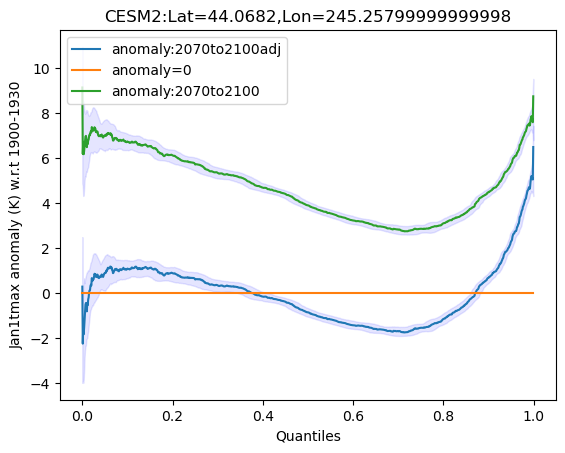

CPU times: user 1.93 s, sys: 81.6 ms, total: 2.01 s
Wall time: 14 s


In [19]:
%%time
quants = np.arange(0,1,0.001)
plt.plot(quants,quca_loc,label='anomaly:2070to2100adj')
plt.plot(quants,yzeros,label='anomaly=0')
plt.fill_between(quants,quca_cilb_loc,quca_ciub_loc,color='b',alpha=0.1)
plt.plot(quants,quwa_loc,label='anomaly:2070to2100')
plt.fill_between(quants,quwa_cilb_loc,quwa_ciub_loc,color='b',alpha=0.1)
plt.legend(loc='upper left')
plt.title('CESM2:Lat='+str(LAT)+',Lon='+str(LON))
plt.ylabel(date+'tmax anomaly (K) w.r.t 1900-1930')
plt.xlabel('Quantiles')
plt.show()

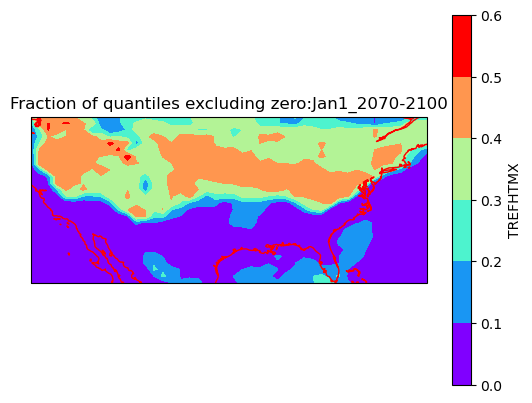

In [40]:
ax       = plt.axes(projection=cart.crs.PlateCarree())
#levs     = np.arange(-2,0.6,0.2)
qus_lbfracn.plot.contourf(ax=ax,cmap='rainbow',transform=cart.crs.PlateCarree())
ax.coastlines(color="red")
plt.title('Fraction of quantiles excluding zero:Jan1_2070-2100')
plt.xlabel('lon')
plt.ylabel('lat')
plt.show()

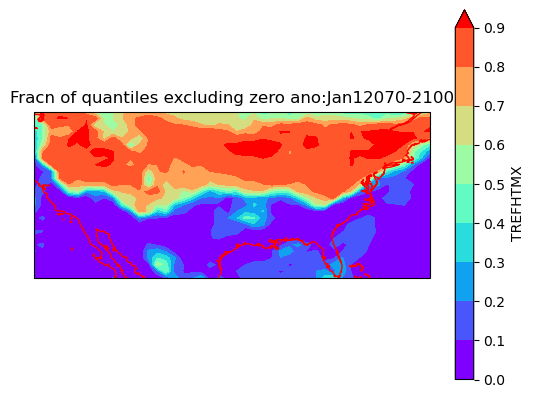

CPU times: user 751 ms, sys: 29.5 ms, total: 780 ms
Wall time: 2.44 s


In [79]:
%%time
ax       = plt.axes(projection=cart.crs.PlateCarree())
levs     = np.arange(0,1,0.1)
quca_fracn.plot.contourf(ax=ax,cmap='rainbow',transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="red")
plt.title('Fracn of quantiles excluding zero ano:Jan12070-2100')
plt.xlabel('lon')
plt.ylabel('lat')
plt.show()

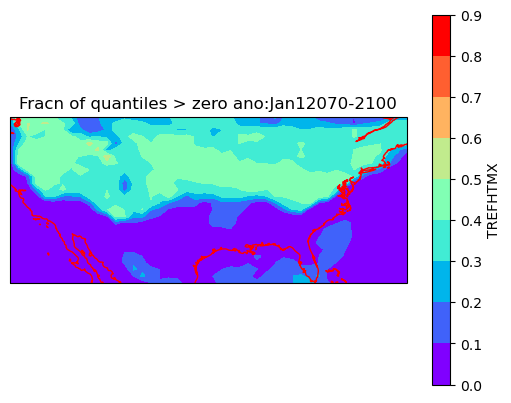

CPU times: user 693 ms, sys: 33.5 ms, total: 726 ms
Wall time: 2.47 s


In [82]:
%%time
ax       = plt.axes(projection=cart.crs.PlateCarree())
levs     = np.arange(0,1,0.1)
quca_fracnp.plot.contourf(ax=ax,cmap='rainbow',transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="red")
plt.title('Fracn of quantiles > zero ano:Jan12070-2100')
plt.xlabel('lon')
plt.ylabel('lat')
plt.show()

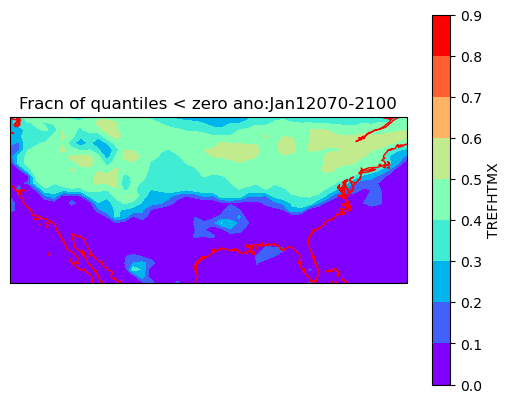

CPU times: user 740 ms, sys: 30.8 ms, total: 770 ms
Wall time: 2.45 s


In [83]:
%%time
ax       = plt.axes(projection=cart.crs.PlateCarree())
levs     = np.arange(0,1,0.1)
quca_fracnn.plot.contourf(ax=ax,cmap='rainbow',transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="red")
plt.title('Fracn of quantiles < zero ano:Jan12070-2100')
plt.xlabel('lon')
plt.ylabel('lat')
plt.show()